# Problem Formulation

In the area of marketing, email is a go-to method for promoting products. It is cheap, fast and effective. Most marketers run an experiment to see whether or not their email-marketing works or not.

In this domain, I would like to analyze whether or not emailing would affect our revenue (by observing the spending by each customer). We'll be looking at factors that can predict spending (in the next few weeks).


## Data description
The dataset used is from the MineThatData E-Mail Analytics And Data Mining Challenge.

This dataset contains 64,000 customers who last purchased within twelve months. The customers were involved in an e-mail test.

1/3 were randomly chosen to receive an e-mail campaign featuring Mens merchandise.

1/3 were randomly chosen to receive an e-mail campaign featuring Womens merchandise.

1/3 were randomly chosen to not receive an e-mail campaign.

During a period of two weeks following the e-mail campaign, results were tracked. Your job is to tell the world if the Mens or Womens e-mail campaign was successful.


### Fields
Historical customer attributes at your disposal include:

**Recency**: Months since last purchase.

**History_Segment:** Categorization of dollars spent in the past year.

**History:** Actual dollar value spent in the past year.

**Mens:** 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.

**Womens:** 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.

**Zip_Code:** Classifies zip code as Urban, Suburban, or Rural.

**Newbie:** 1/0 indicator, 1 = New customer in the past twelve months.

**Channel:** Describes the channels the customer purchased from in the past year.
  


Another variable describes the e-mail campaign the customer received:

**Segment** Mens E-Mail, Womens E-Mail, No E-Mail

Finally, we have a series of variables describing activity in the two weeks following delivery of the e-mail campaign:

**Visit:** 1/0 indicator, 1 = Customer visited website in the following two weeks.

**Conversion:** 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.

**Spend:** Actual dollars spent in the following two weeks.


## Limitations/Assumptions:
The original campaign had 2 treatments (one group were sent emails featuring men's products and the other women's products), while the control being no e-mail was sent. For the sake of simplicity I am only limiting my experiment to a single treatment (men's product) and dropping the data for the other treatment.


## Main Steps

1. Data Exploration
2. Filtering Data
3. Propensity Estimation
4. Regression Analysis
5. DoWhy 

> * Calculate Treatment Effects based on common causes, Viewing Causal Model
* Viewing Causal Model
* Effect Identification
* Estimation of Effect 
* Refutation of Estimate (Random Subset, Random Common Cause, Placebo Variable)

6. Causal ML (XLearner, TLearner, SLearner, RLearner)

> * Calculate Average Treatment Effect
* Individual Treatment Effects
* Feature Importance

In [1]:
# Installing Dependencies
!pip install dowhy
!pip install causalml
!pip install scikit-uplift

You should consider upgrading via the 'c:\users\apoorva\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\apoorva\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\apoorva\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Data Exploration

In [2]:
# Importing Libraries
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklift.datasets import fetch_hillstrom
from sklearn.model_selection import train_test_split

# import warnings
# warnings.filterwarnings("ignore")

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd

# Load the dataset
dataset = pd.read_csv("Email Mining Dataset.csv")

# Extracting data, target, and treatment
data = dataset.drop(columns=['visit', 'conversion', 'spend', 'segment'])  # 'segemnt' as treatment
target = dataset[['visit', 'conversion', 'spend']]  # Assuming these are target variables
treatment = dataset['segment']  # Assuming 'segment' is the treatment variable

# Renaming target columns
target.columns = ['target_' + col for col in target.columns]

# Appending treatment and target columns to the data DataFrame
db = data.copy()
db['treatment'] = treatment  # Adding the treatment column
db = pd.concat([db, target], axis=1)  # Concatenating the target columns

# Display the first few rows of the resulting DataFrame
db.head()


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target_visit,target_conversion,target_spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.00
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.00
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.00
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.00
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.00


In [4]:
# Viewing the target variable
db.target_visit.describe()

count   64,000.00
mean         0.15
std          0.35
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: target_visit, dtype: float64

In [5]:
# Looking at column datatypes
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recency            64000 non-null  int64  
 1   history_segment    64000 non-null  object 
 2   history            64000 non-null  float64
 3   mens               64000 non-null  int64  
 4   womens             64000 non-null  int64  
 5   zip_code           64000 non-null  object 
 6   newbie             64000 non-null  int64  
 7   channel            64000 non-null  object 
 8   treatment          64000 non-null  object 
 9   target_visit       64000 non-null  int64  
 10  target_conversion  64000 non-null  int64  
 11  target_spend       64000 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


In [6]:
# Identifying categorical columns
catcols = list(db.dtypes[db.dtypes == object].index)
db.describe(include='object').T

,count,unique,top,freq
history_segment,64000,7,1) $0 - $100,22970
zip_code,64000,3,Surburban,28776
channel,64000,3,Web,28217
treatment,64000,3,Womens E-Mail,21387


In [7]:
# Unique categories
set(np.concatenate(db[catcols].values))

{'1) $0 - $100',
 '2) $100 - $200',
 '3) $200 - $350',
 '4) $350 - $500',
 '5) $500 - $750',
 '6) $750 - $1,000',
 '7) $1,000 +',
 'Mens E-Mail',
 'Multichannel',
 'No E-Mail',
 'Phone',
 'Rural',
 'Surburban',
 'Urban',
 'Web',
 'Womens E-Mail'}

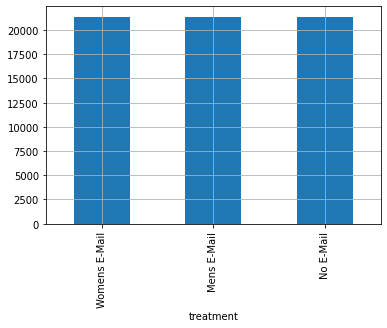

In [8]:
# Looking at number of participants in control-treatments
db.treatment.value_counts().plot(kind="bar", grid=True);

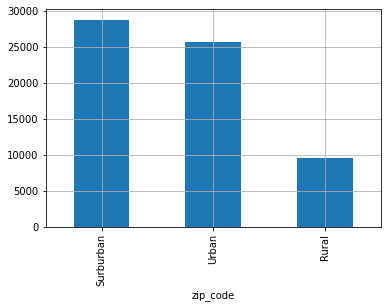

In [9]:
# Looking at distribution of zipcode categories
db.zip_code.value_counts().plot(kind="bar", grid=True);

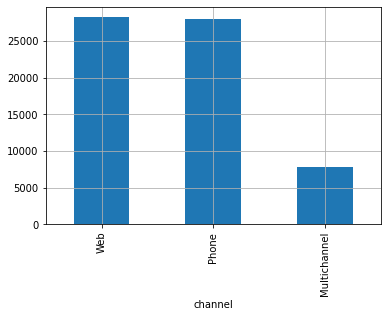

In [10]:
# Looking at purchase channel
db.channel.value_counts().plot(kind="bar", grid=True);

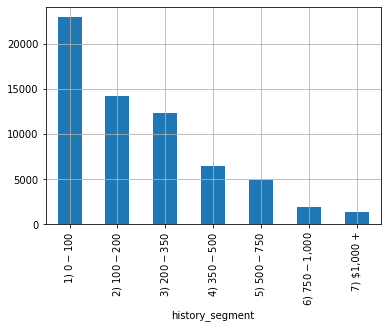

In [11]:
# Looking at the category of purchaes
db.history_segment.value_counts().plot(kind="bar", grid=True);

<Axes: xlabel='recency'>

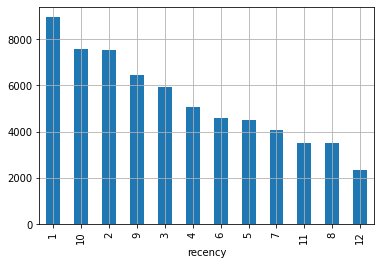

In [12]:
# Looking at months since last purchase
db.recency.value_counts().plot(kind="bar", grid=True)

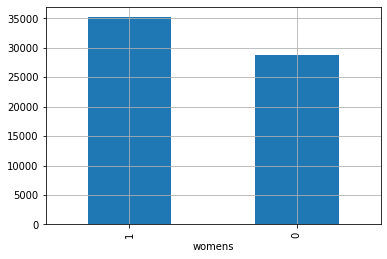

In [13]:
# Looking at whether women's products were bought
db.womens.value_counts().plot(kind="bar", grid=True);

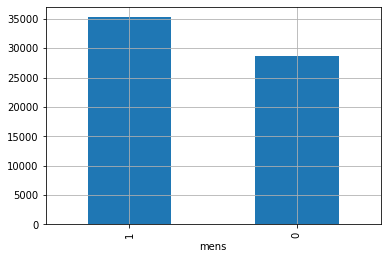

In [14]:
# Looking at whether men's products were bought
db.mens.value_counts().plot(kind="bar", grid=True);

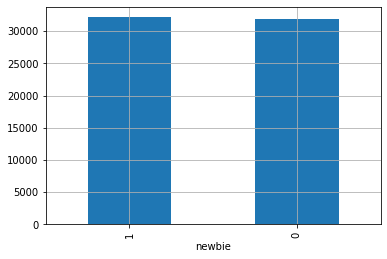

In [15]:
# Looking at new customers distribution
db.newbie.value_counts().plot(kind="bar", grid=True);

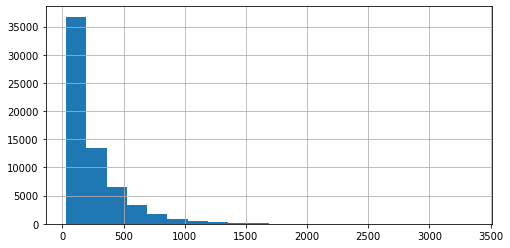

In [16]:
# Looking at spending amount in the last year
db.loc[:, "history"].hist(figsize=(8, 4), bins=20, grid=True);

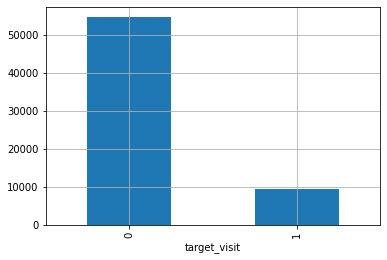

In [17]:
# Looking at visits
db.target_visit.value_counts().plot(kind="bar", grid=True);

In [18]:
# Feature variables X
# List of feature columns: excluding the target columns
features = np.setdiff1d(db.columns, ["target_visit", "treatment", "target_spend", "target_conversion"] ).tolist()
dfX = db[features]
dfX.tail(4)

,channel,history,history_segment,mens,newbie,recency,womens,zip_code
63996,Phone,38.91,1) $0 - $100,0,1,5,1,Urban
63997,Phone,29.99,1) $0 - $100,1,1,6,0,Urban
63998,Multichannel,552.94,5) $500 - $750,1,1,1,0,Surburban
63999,Web,472.82,4) $350 - $500,0,0,1,1,Surburban


In [19]:
# One-hot encoding: categorical to numerical
dfXn = pd.get_dummies(dfX)
dfXn.tail(4)

,history,mens,newbie,recency,womens,channel_Multichannel,channel_Phone,channel_Web,history_segment_1) $0 - $100,history_segment_2) $100 - $200,history_segment_3) $200 - $350,history_segment_4) $350 - $500,history_segment_5) $500 - $750,"history_segment_6) $750 - $1,000","history_segment_7) $1,000 +",zip_code_Rural,zip_code_Surburban,zip_code_Urban
63996,38.91,0,1,5,1,False,True,False,True,False,False,False,False,False,False,False,False,True
63997,29.99,1,1,6,0,False,True,False,True,False,False,False,False,False,False,False,False,True
63998,552.94,1,1,1,0,True,False,False,False,False,False,False,True,False,False,False,True,False
63999,472.82,0,0,1,1,False,False,True,False,False,False,True,False,False,False,False,True,False


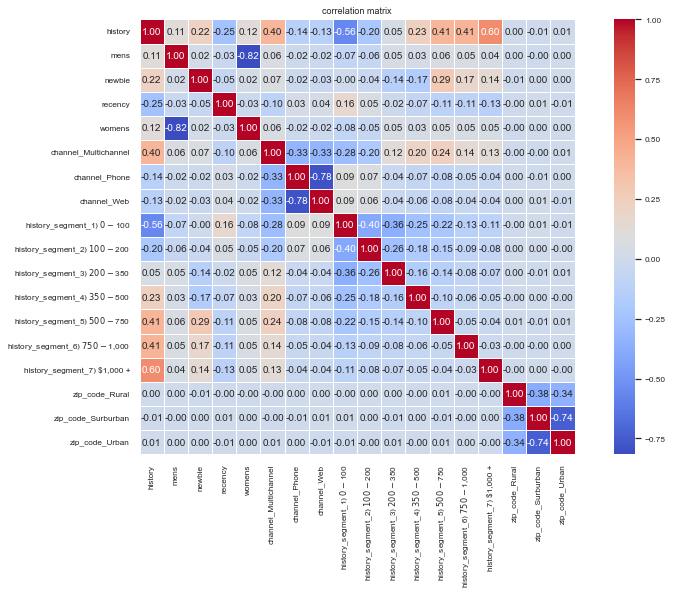

In [20]:
# Correlation of features
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
sns.heatmap(dfXn.corr().round(3), annot=True, square = True, \
    linewidths=.75, cmap="coolwarm", fmt = ".2f", annot_kws = {"size": 10} )
plt.title("correlation matrix")
plt.show()

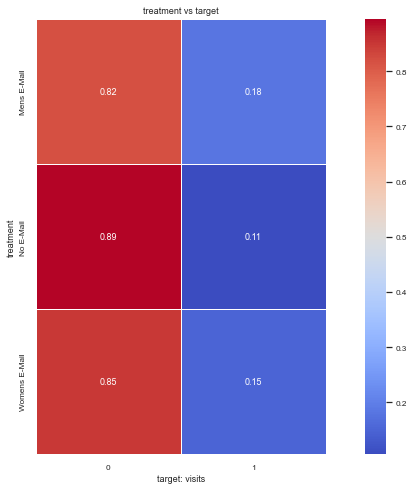

In [21]:
# treatment vs target: visits
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
crosstab = pd.crosstab(db.treatment, db.target_visit, normalize="index")
    
sns.heatmap(crosstab, annot=True, fmt=".2f", linewidths=1, square = True, cmap = "coolwarm")
plt.xlabel("target: visits")
plt.title("treatment vs target");

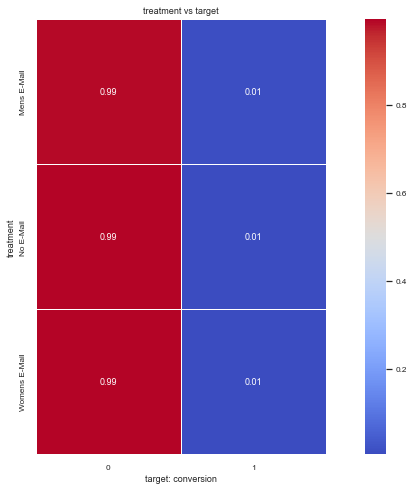

In [22]:
# treatment vs target: conversion
plt.figure(figsize = (14,8))
sns.set(font_scale=0.75)
crosstab = pd.crosstab(db.treatment, db.target_conversion, normalize="index")
    
sns.heatmap(crosstab, annot=True, fmt=".2f", linewidths=1, square = True, cmap = "coolwarm")
plt.xlabel("target: conversion")
plt.title("treatment vs target");

### Checking distributions

C:\Users\Apoorva\AppData\Local\Temp/ipykernel_26140/3454470669.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  ax = sns.barplot(x="treatment", y="target_visit", data=db, estimator=np.mean, ci=90, capsize=.2, order = sorted(set(db['treatment'])))


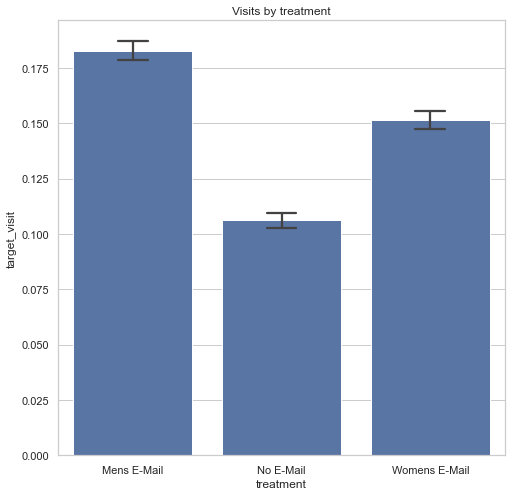

In [23]:
# Visits Distribution
sns.set(rc={'figure.figsize':(8,8)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="treatment", y="target_visit", data=db, estimator=np.mean, ci=90, capsize=.2, order = sorted(set(db['treatment'])))
ax.set_title('Visits by treatment')
plt.show()

C:\Users\Apoorva\AppData\Local\Temp/ipykernel_26140/1308103122.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  ax = sns.barplot(x="treatment", y="target_conversion", data=db, estimator=np.mean, ci=90, capsize=.2, order = sorted(set(db['treatment'])))


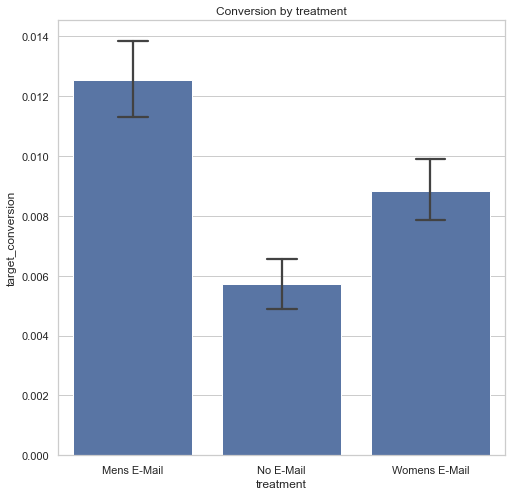

In [24]:
# Spending Distribution
sns.set(rc={'figure.figsize':(8,8)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="treatment", y="target_conversion", data=db, estimator=np.mean, ci=90, capsize=.2, order = sorted(set(db['treatment'])))
ax.set_title('Conversion by treatment')
plt.show()

C:\Users\Apoorva\AppData\Local\Temp/ipykernel_26140/32147000.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  ax = sns.barplot(x="treatment", y="target_spend", data=db, estimator=np.sum, ci=90, capsize=.2, order = sorted(set(db['treatment'])))


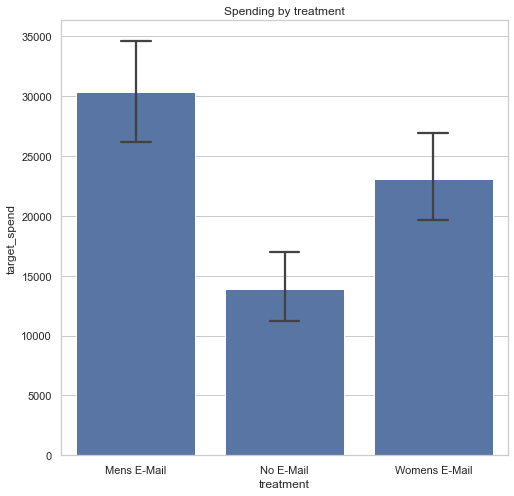

In [25]:
# Spending Distribution
sns.set(rc={'figure.figsize':(8,8)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="treatment", y="target_spend", data=db, estimator=np.sum, ci=90, capsize=.2, order = sorted(set(db['treatment'])))
ax.set_title('Spending by treatment')
plt.show()

# Filtering Data

In [26]:
# Define Men's E-Mail as treatment = 1, all others as 0
db = db[db.treatment != 'Womens E-Mail']
treat = {   #"Womens E-Mail": 1,
            "No E-Mail": 0, 
            "Mens E-Mail": 1
        }
db['treat_men'] = db.treatment.map(treat)
db.drop(['target_visit', 'target_conversion', 'treatment'], axis=1, inplace=True)
db.drop('history_segment', axis=1, inplace=True) # Redundant as segmentation based on history of expense 

# Propensity Estimation

In [27]:
# Estimating Propensity Score (Using Logistic Regression)
from sklearn.linear_model import LogisticRegression
T = db['treat_men']
Y = db['target_spend']
X = pd.get_dummies(db, columns=['zip_code', 'channel'], drop_first=False).drop(['treat_men', 'target_spend'], axis=1)

ps_model = LogisticRegression(C=1e6).fit(X, T)
db = db.assign(propensity_score=ps_model.predict_proba(X)[:, 1])
db.head()

,recency,history,mens,womens,zip_code,newbie,channel,target_spend,treat_men,propensity_score
1,6,329.08,1,1,Rural,1,Web,0.00,0,0.51
3,9,675.83,1,0,Rural,1,Web,0.00,1,0.52
8,9,675.07,1,1,Rural,1,Phone,0.00,1,0.51
13,2,101.64,0,1,Urban,0,Web,0.00,1,0.50
14,4,241.42,0,1,Rural,1,Multichannel,0.00,0,0.50


In [28]:
# Sanity check to see if the propensity score matches population sample size
weight_t = 1/db.query("treat_men==1")["propensity_score"]
weight_nt = 1/(1-db.query("treat_men==0")["propensity_score"])
print("Original Sample Size", db.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 42613
Treated Population Sample Size 42611.02215507853
Untreated Population Sample Size 42614.98223172761


#### We observe that the treatment vs non-treatment are well-balanced as there is high overlap and the propensity scores are centered around 50%

<Axes: xlabel='propensity_score', ylabel='Count'>

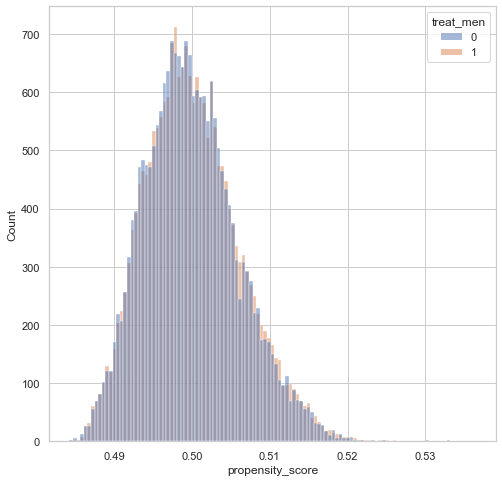

In [29]:
  sns.histplot(data=db, x="propensity_score", hue='treat_men')

### Using this propensity score we can figure out the ATE

In [30]:
weight = ((db["treat_men"]-db["propensity_score"]) /
          (db["propensity_score"]*(1-db["propensity_score"])))

y1 = sum(db.query("treat_men==1")["target_spend"]*weight_t) / len(db)
y0 = sum(db.query("treat_men==0")["target_spend"]*weight_nt) / len(db)

ate = np.mean(weight * db["target_spend"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", np.mean(weight * db["target_spend"]))

Y1: 1.4207718733159915
Y0: 0.6536340739031241
ATE 0.767137799412868


#### Since we have random assignment (and balanced assignment) across treatment and control groups, we can simply observe the ATE

In [31]:
db.groupby('treat_men')['target_spend'].mean()

treat_men
0   0.65
1   1.42
Name: target_spend, dtype: float64

In [32]:
df = pd.get_dummies(db, columns=['zip_code', 'channel'], drop_first=True)
df.head()

,recency,history,mens,womens,newbie,target_spend,treat_men,propensity_score,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
1,6,329.08,1,1,1,0.00,0,0.51,False,False,False,True
3,9,675.83,1,0,1,0.00,1,0.52,False,False,False,True
8,9,675.07,1,1,1,0.00,1,0.51,False,False,True,False
13,2,101.64,0,1,0,0.00,1,0.50,False,True,False,True
14,4,241.42,0,1,1,0.00,0,0.50,False,False,False,False


## Simply Linear Regression for estimating coefficients and significance

In [33]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='target_spend ~ treat_men + recency + womens + mens + newbie + zip_code_Urban + zip_code_Surburban + channel_Web + channel_Phone', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           target_spend   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.308
Date:                Wed, 18 Sep 2024   Prob (F-statistic):           1.80e-12
Time:                        22:23:33   Log-Likelihood:            -1.7582e+05
No. Observations:               42613   AIC:                         3.517e+05
Df Residuals:                   42603   BIC:                         3.517e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

##### We can add interaction effects on top of this. As an example we want to study the interactive effects of treatment on newbies. We realize a non-significant effect (17% p-value)

In [34]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='target_spend ~ treat_men + recency + womens + mens + newbie + zip_code_Urban + zip_code_Surburban + channel_Web + channel_Phone + treat_men:newbie', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           target_spend   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.665
Date:                Wed, 18 Sep 2024   Prob (F-statistic):           2.33e-12
Time:                        22:23:33   Log-Likelihood:            -1.7581e+05
No. Observations:               42613   AIC:                         3.517e+05
Df Residuals:                   42602   BIC:                         3.517e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# DoWhy

In [35]:
import logging
import dowhy
from dowhy import CausalModel
import dowhy.datasets

Investigating effect of our most important predictors to see the affects on treatment. While we know that the experiment is well-balanced, this framework can be applied to un-balanced data and we would see the actual affect across a variable (Average + Conditional Effect) in cases where the data is heterogeneous. Let's take recency and estimate treatment affect.

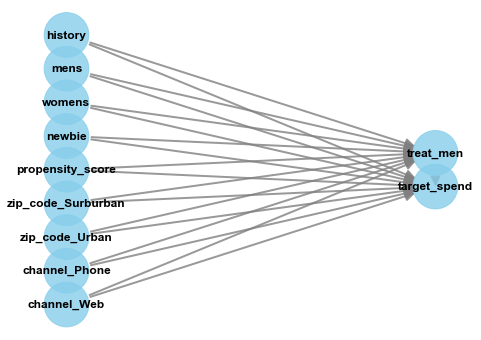

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
───────────(E[target_spend|womens,newbie,zip_code_Surburban,channel_Phone,mens ↪
d[treatₘₑₙ]                                                                    ↪

↪                                                       
↪ ,history,propensity_score,channel_Web,zip_code_Urban])
↪                                                       
Estimand assumption 1, Unconfoundedness: If U→{treat_men} and U→target_spend then P(target_spend|treat_men,womens,newbie,zip_code_Surburban,channel_Phone,mens,history,propensity_score,channel_Web,zip_code_Urban,U) = P(target_spend|treat_men,womens,newbie,zip_code_Surburban,channel_Phone,mens,history,propensity_score,channel_Web,zip_code_Urban)

## Realized estimand
b: target_spend~treat_men+womens+newbie+zip_code_Surburban+c

c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [36]:
# Instrument Variables were not specified here
investigate_columns = 'recency'
causes_columns = list(df.columns.drop([investigate_columns, 'treat_men', 'target_spend']))
model = CausalModel(
  data = df,
  treatment = 'treat_men',
  outcome = 'target_spend',
  common_causes = causes_columns)
model.view_model() # View the model
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
                              method_name="backdoor.linear_regression",
                            test_significance = True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

Refuting Affect with a random common cause. No change in effect

In [37]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is d

Refute: Add a random common cause
Estimated effect:0.7668734135539701
New effect:0.7668965393882046
p value:0.8999999999999999



c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Refuting Affect with a random subset of data. No change in effect

In [38]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is d

Refute: Use a subset of data
Estimated effect:0.7668734135539701
New effect:0.7694243350392668
p value:0.94



c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Refuting Affect with a random placebo variable. No change in effect

In [39]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is d

Refute: Use a Placebo Treatment
Estimated effect:0.7668734135539701
New effect:-0.00111635853748165
p value:0.98



c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Repeating the same assessment for various other features. We observe the same Treatment Effect (as per our pervious analysis we did observed good randomization and balancedness so this is expected)

In [40]:
# Same analysis can be repeated for an array of features
top_features = ['recency', 'history', 'zip_code_Surburban', 'channel_Phone']
effects = dict()
for investigate_columns in top_features:
    causes_columns = list(df.columns.drop([investigate_columns, 'treat_men', 'target_spend']))
    model = CausalModel(
    data = df,
    treatment = 'treat_men',
    outcome = 'target_spend',
    common_causes = causes_columns)
    # model.view_model() # View the model
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                              test_significance = True)
    effects[investigate_columns] = estimate.value
    # print(estimate)
    # print("Causal Estimate is " + str(estimate.value))

c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Apoorva\AppData\Local\Programs\Python\Python39\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is d

In [41]:
effects

{'recency': np.float64(0.7668734135539701),
 'history': np.float64(0.7668726849318509),
 'zip_code_Surburban': np.float64(0.7668730097266845),
 'channel_Phone': np.float64(0.7668728286920761)}

# Causal ML

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [43]:
plt.style.use('fivethirtyeight')

In [44]:
y, X, w, e = np.array(df.target_spend), np.array(df.drop(['target_spend', 'treat_men' , 'propensity_score'], axis=1)), np.array(df.treat_men), np.array(df.propensity_score)

# To keep variable names consistent in the code below
treatment=w
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])

In [45]:
feature_names = df.drop(['target_spend', 'treat_men' , 'propensity_score'], axis=1).columns

### Calculate Average Treatment Effect (ATE)
A meta-learner can be instantiated by calling a base learner class and providing an sklearn/xgboost regressor class as input. Alternatively, we have provided some ready-to-use learners that have already inherited their respective base learner class capabilities. This is more abstracted and allows these tools to be quickly and readily usable.

In [46]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.77]), array([0.48]), array([1.05]))
ATE estimate: 0.767
ATE lower bound: 0.483
ATE upper bound: 1.051


In [47]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

[01:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the ready-to-use XGBTRegressor class
(array([0.75]), array([0.48]), array([1.01]))
[01:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Using the BaseTRegressor class and using XGB (same result):
(array([0.75]), array([0.48]), array([1.01]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.77]), array([0.48]), array([1.05]))


In [48]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

[01:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:39:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB:
(array([0.73]), array([0.46]), array([1.]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.77]), array([0.48]), array([1.05]))


In [49]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

[01:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseXRegressor class and using XGB without propensity score input:
(array([0.73]), array([0.46]), array([1.]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.77]), array([0.48]), array([1.05]))


In [50]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

[01:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB:
(array([0.76]), array([0.75]), array([0.76]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.77]), array([0.77]), array([0.77]))


In [51]:
# R Learner with propensity score input and random sample weight
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
sample_weight = np.random.randint(1, 3, len(y))
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e, sample_weight=sample_weight)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

[01:42:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB:
(array([0.74]), array([0.74]), array([0.74]))


In [52]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

[01:44:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Using the BaseRRegressor class and using XGB without propensity score input:
(array([0.74]), array([0.73]), array([0.74]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([0.77]), array([0.76]), array([0.77]))


### 7. Calculate Individual Treatment Effect (ITE/CATE)
CATE stands for Conditional Average Treatment Effect.

In [53]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

[01:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:45:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:45:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:46:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### We observe similiar results (as we had Randomized Controlled Trials).

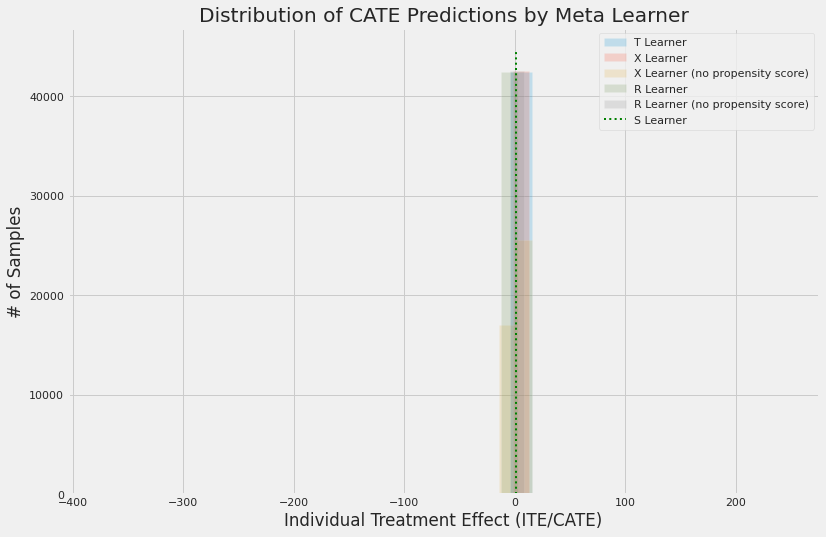

In [54]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

# Feature Importance

## S Learner

In [58]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.77])

In [59]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [60]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': history              0.40
 recency              0.20
 mens                 0.07
 zip_code_Urban       0.07
 womens               0.06
 channel_Phone        0.05
 newbie               0.05
 zip_code_Surburban   0.05
 channel_Web          0.04
 dtype: float64}

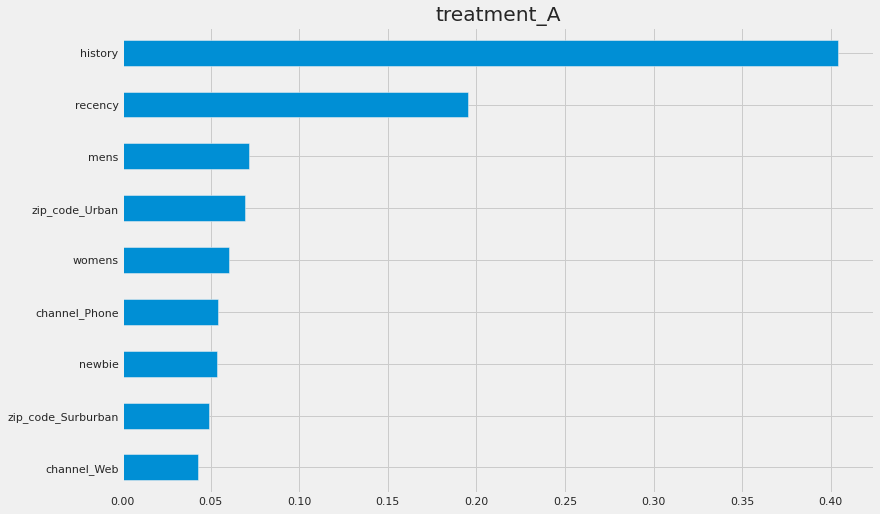

In [61]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [62]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': history              1.15
 recency              0.48
 newbie               0.22
 zip_code_Urban       0.21
 mens                 0.21
 womens               0.18
 channel_Phone        0.12
 zip_code_Surburban   0.11
 channel_Web          0.10
 dtype: float64}

In [63]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 3.3510842323303223 seconds


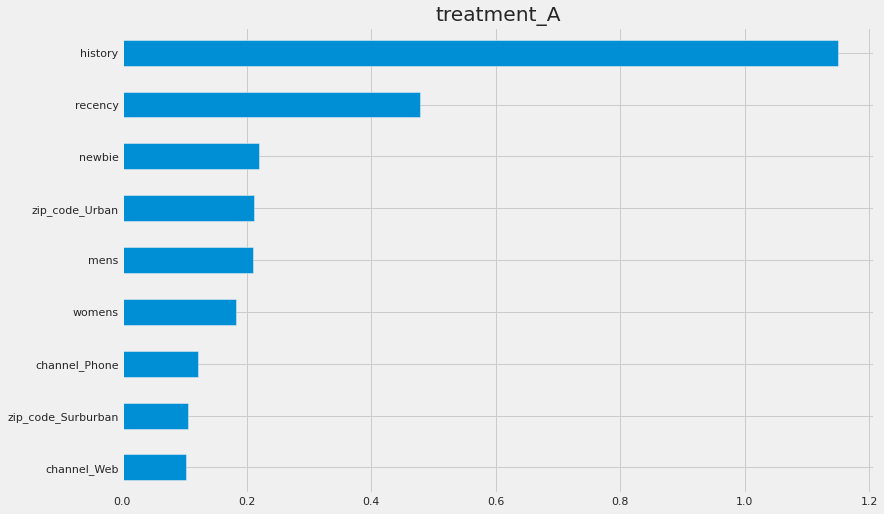

In [64]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [67]:
model_tau = LGBMRegressor(importance_type='gain')
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 3.435340166091919 seconds


In [68]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

history              1.15
recency              0.48
newbie               0.22
zip_code_Urban       0.21
mens                 0.21
womens               0.18
channel_Phone        0.12
zip_code_Surburban   0.11
channel_Web          0.10
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

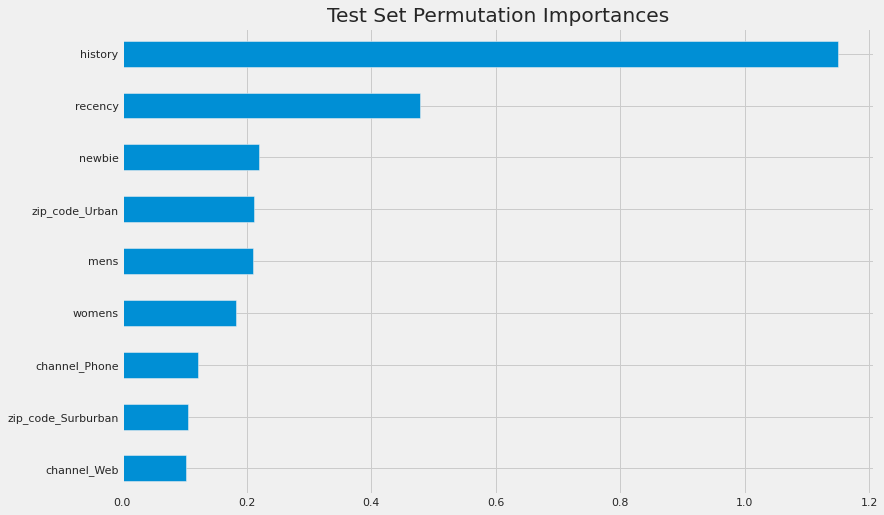

In [69]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [70]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

history              1.22
recency              0.50
mens                 0.24
newbie               0.22
zip_code_Urban       0.21
womens               0.19
zip_code_Surburban   0.12
channel_Phone        0.12
channel_Web          0.09
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

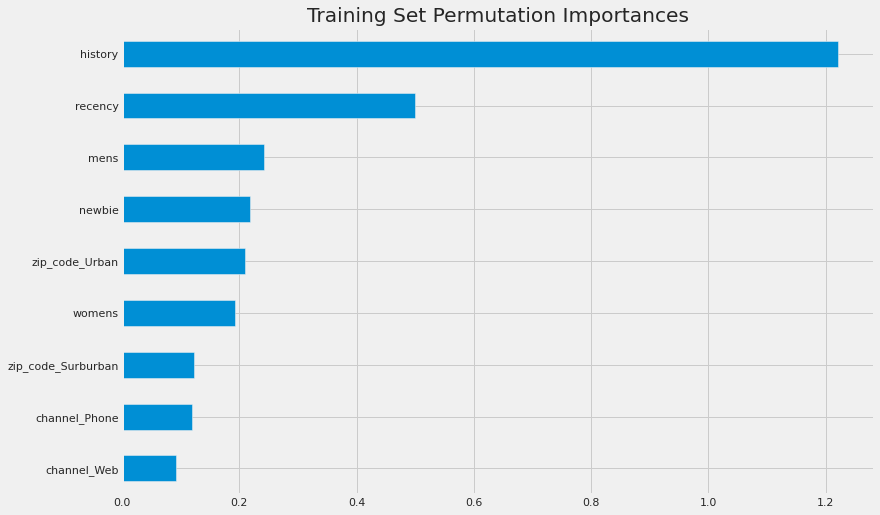

In [71]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [72]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[-0.04, -0.31,  0.17, ...,  0.02,  0.01,  0.03],
        [ 0.14,  0.23,  0.11, ...,  0.03,  0.02,  0.08],
        [ 0.15,  0.32,  0.15, ...,  0.03, -0.01, -0.04],
        ...,
        [-0.07, -0.06, -0.23, ..., -0.03, -0.04, -0.01],
        [-0.17, -0.  ,  0.2 , ..., -0.03, -0.03, -0.01],
        [-0.06,  0.06, -0.09, ...,  0.09,  0.03,  0.15]])}

In [73]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([0.2 , 0.42, 0.19, 0.16, 0.13, 0.07, 0.07, 0.06, 0.06])

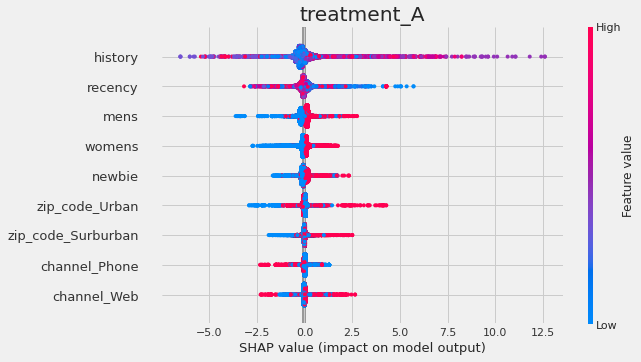

In [74]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

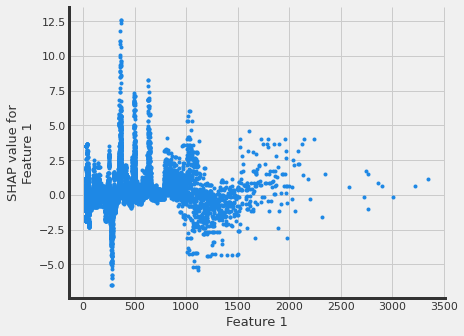

In [75]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

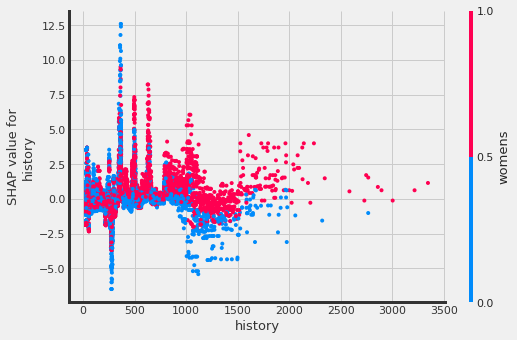

In [76]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='history',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

# Summary

Tl;dr: We run a randomized experiments and do not observe any significnant heterogeneity effects across the observed groups. This is validated by simple balancedness checks, heterogeneity checks and uplift-modelling giving estimates that are close to the Average Treatment Effect. 

#### Hypothesis Testing

Our initial findings showed that the available email-campaign data is close to a Randomized Controlled Trial, where there are no biases observed amongst the treatment and control groups. We find that there was a *significant* increase in average spending of the group which were sent emails regarding products for men compared to customers who were not sent emails. The conditional treatment effect is non-existent here. This is observed by using variuos Regressors (CausalML & DoWhy), where the treatment effect (after accounting for counfounders) is close to the Average Treatment Effect.

#### Feature Importance

Our various regressors show that our top features that go into the prediction of the spending in the future (next few weeks) are:
- History (Money spent by the customer in the previous year)
- Recency (Months since last purchase)
- Mens (Whether they bought mens products before)
- Newbie (Whether they were a newbie or not)
- Urban Zip Code

